# Validation of Pypsa-Eur model

## Analysis of PyPSA-Eur Model

This notebook investigates the results obtained from the **PyPSA-Eur** model. In particular, publicly available information about the European power system is compared to the data used and the results produced by the PyPSA-Eur model.

The following quantities are reviewed:

### Inputs Used by the PyPSA-Eur Model
- **Renewable Installable Potential** for Solar and Wind
- **Installed Generation Capacity** by Technology Type

### Outputs of the Simulation
- **Electricity Demand**
- **Hydropower Energy Production**

### Reproducing the Results

To properly reproduce the findings presented in this notebook, please run the full **Snakemake** workflow for **PyPSA-Eur**. 

You can find detailed installation and execution instructions in the official documentation:  
🔗 [PyPSA-Eur Installation Guide](https://pypsa-eur.readthedocs.io/en/stable/installation.html)

Alternatively, if you have access to a pre-built version of the model, you may use that directly.

This validation step is essential for:
- Ensuring the PyPSA-Eur model's  data reflects reality.
- Highlighting discrepancies, if any, between model data and real-world statistics.
- Supporting transparency and reliability in energy system modeling.


## Preparation

### Import Packages

In [1]:
# ==============================
# Imports
# ==============================

# Core libraries
import os
import sys
import logging
from pathlib import Path
from datetime import datetime
from itertools import product

# Scientific and data processing libraries
import numpy as np
import pandas as pd
import xarray as xr
import scipy as sp
from scipy.sparse import csgraph
import networkx as nx
import yaml

# Plotting libraries
import matplotlib.pyplot as plt
import seaborn as sns
import cartopy.crs as ccrs

# Geospatial libraries
import geopandas as gpd
from shapely.geometry import Point, LineString
import shapely
import shapely.prepared
import shapely.wkt

# PyPSA
import pypsa
from pypsa.plot import add_legend_circles, add_legend_lines, add_legend_patches

# ==============================
# Settings
# ==============================

# Plotting styles
plt.style.use("bmh")
sns.set(style="darkgrid")

# Logging
logger = logging.getLogger(__name__)

# Pandas display settings
pd.set_option("display.max_columns", None)
pd.set_option("display.max_colwidth", 70)

# Custom plotting parameters
max_node_size = 1.0  # maximum size of a node for plotting purposes


### Loading the Solved Network

To load the solved PyPSA-Eur network, make sure your file path points to the correct `.nc` file generated by the Snakemake workflow.

If your project follows the default directory structure, you can use a relative path:

```python
import pypsa

n = pypsa.Network("../results/networks/base_s_39_elec_.nc")


In [5]:
# Path to the solved network
network_path = "../results/validation_2023_new/networks/base_s_39_elec_.nc"
n = pypsa.Network(network_path)




INFO:pypsa.io:Imported network base_s_39_elec_.nc has buses, carriers, generators, global_constraints, lines, links, loads, storage_units, stores


### Plot Network

/tmp/ipykernel_58473/1768564593.py:1: DeprecatedWarning: plot is deprecated. Use `n.plot.map()` as a drop-in replacement instead.
  n.plot();


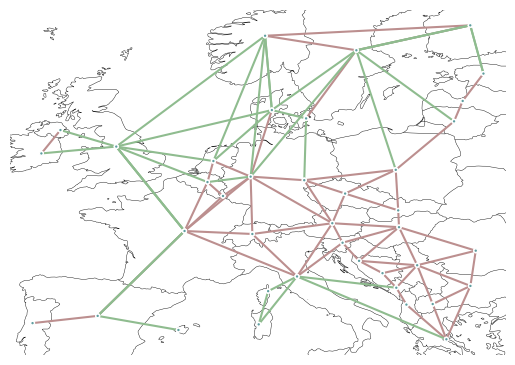

In [6]:
n.plot();

## Current Capacity of the Energy System

### Geospatial Visualization of an Energy Network Using PyPSA

This code generates a **geospatial visualization** of an energy network model using the **PyPSA**  framework. It plots **buses (nodes)**, **lines**, and **links** on a map of onshore regions. The script leverages:

- **GeoPandas** for handling geospatial data,
- **Matplotlib** for visualization,
- **Cartopy** for map projections.

Below is a high-level breakdown of the key steps performed by the code:

---

#### 1. Load Geospatial Data
- Reads a `.geojson` file containing onshore region shapes.
- These shapes serve as the **background map layer**, giving spatial context to the energy network.

---

####  2. Prepare Network Data
- Ensures that all **energy carriers** in the network have valid color attributes.
- Missing (`NaN`) or empty (`''`) color values are replaced with **`'gray'`** to prevent plotting issues.

---

####  3. Configure Plot Settings
- Defines **scaling factors**:
  - `bus_scale` for bus (node) sizes,
  - `line_scale` for transmission line widths.
- Specifies standard **legend sizes** for buses and lines (in MW).

---

####  4. Calculate Bus Sizes
- Aggregates installed capacities for:
  - **Generators** (excluding load),
  - **Storage units**.
- Groups data by **bus and carrier** to determine the appropriate size of each node in the visualization.

---

####  5. Plot the Network
- Uses `n.plot()` to:
  - Draw the network layout,
  - Scale buses based on capacity,
  - Adjust line and link widths based on nominal power,
  - Apply a consistent **color scheme** for all elements.

---

####  6. Add Region Overlay
- Overlays the onshore regions as a **background map layer**.
- Uses light colors (`whitesmoke`) and white borders for visual clarity.

---

####  7. Set Map Extent
- Automatically sets the **map boundaries** based on the total extent of the loaded regions, ensuring all relevant data is in view.

---

####  8. Add Legends
- Adds **three legends** outside the plot:
  - **Bus size legend** (in GW),
  - **Line size legend** (in GW),
  - **Carrier type legend** (with color patches).
- Improves interpretability for stakeholders and readers.

---

####  9. Finalize and Display
- Applies a **tight layout** to optimize spacing.
- Calls `plt.show()` to render the **final visual output**.

---

**Result**: A clear, data-rich **map of the energy network** showing generation, storage, and transmission infrastructure over a geographic base map.

/tmp/ipykernel_58473/3191650180.py:26: DeprecatedWarning: plot is deprecated. Use `n.plot.map()` as a drop-in replacement instead.
  n.plot(
/home/user/miniconda3/envs/pypsa-eur_Ember-Flexibility-Study/lib/python3.12/site-packages/pypsa/plot/accessor.py:34: DeprecationWarning: `color_geomap` is deprecated as an argument to `plot`; use `geomap_colors` instead.
  return plot(self.n, *args, **kwargs)
/tmp/ipykernel_58473/3191650180.py:55: DeprecationWarning: The namespace `pypsa.plot.add_legend_circles` is deprecated and will be removed in a future version. Please use the new namespace `pypsa.plot.maps.static.add_legend_circles` instead.
  add_legend_circles(
/home/user/miniconda3/envs/pypsa-eur_Ember-Flexibility-Study/lib/python3.12/site-packages/pypsa/plot/maps/static.py:1678: UserWarning: When combining n.plot() with other plots on a geographical axis, ensure n.plot() is called first or the final axis extent is set initially (ax.set_extent(boundaries, crs=crs)) for consistent legend ci

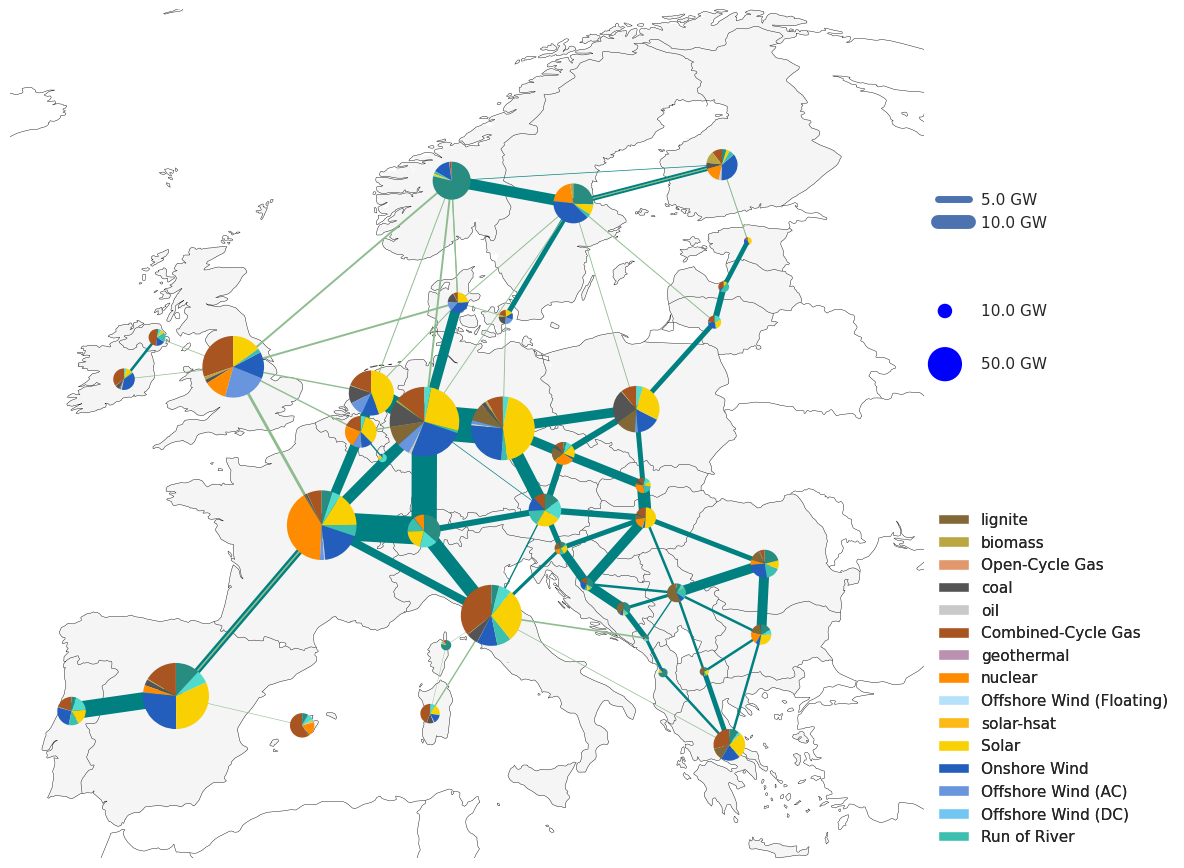

In [29]:

# Load regions
regions_onshore_path = "../resources/validation_2023_new/country_shapes.geojson"
regions_onshore = gpd.read_file(regions_onshore_path)

# Fix missing or empty colors in carriers
n.carriers['color'] = n.carriers['color'].fillna('gray')  # Replace NaN with 'gray'
n.carriers.loc[n.carriers['color'] == '', 'color'] = 'gray'  # Replace empty strings with 'gray'

# Scale settings (adjusted to reduce node sizes)
bus_scale = 5e4  # Increased from 6e3 to make nodes smaller
line_scale = 1e3  # Keep as is, since only nodes need adjustment

# Legend settings
bus_sizes = [10000, 50000]  # in MW
line_sizes = [5000, 10000]  # in MW

# Plotting
fig, ax = plt.subplots(figsize=(12, 12), subplot_kw={"projection": ccrs.EqualEarth(n.buses.x.mean())})

# Calculate bus sizes based on generator and storage capacities
gen = n.generators[n.generators.carrier != "load"].groupby(["bus", "carrier"]).p_nom.sum()
sto = n.storage_units.groupby(["bus", "carrier"]).p_nom.sum()
buses = pd.concat([gen, sto])

with plt.rc_context({"patch.linewidth": 0.}):
    n.plot(
        bus_sizes=buses / bus_scale,  # Use adjusted bus_scale
        bus_alpha=1.0,
        line_widths=n.lines.s_nom_opt / line_scale,
        link_widths=n.links.p_nom_opt / line_scale,
        line_colors="teal",
        ax=ax,
        margin=0.2,
        color_geomap=None,
    )

# Plot regions
regions_onshore.plot(
    ax=ax,
    facecolor="whitesmoke",
    edgecolor="white",
    aspect="equal",
    transform=ccrs.PlateCarree(),
    linewidth=0,
)

# Set extent
ax.set_extent(regions_onshore.total_bounds[[0, 2, 1, 3]])

# Legend settings
legend_kwargs = {"loc": "upper left", "frameon": False}
legend_circles_dict = {"bbox_to_anchor": (1, 0.67), "labelspacing": 2.5, **legend_kwargs}

# Add legends
add_legend_circles(
    ax,
    [s / bus_scale for s in bus_sizes],  # Legend sizes scaled by bus_scale
    [f"{s / 1000} GW" for s in bus_sizes],
    legend_kw=legend_circles_dict,
)

add_legend_lines(
    ax,
    [s / line_scale for s in line_sizes],
    [f"{s / 1000} GW" for s in line_sizes],
    legend_kw={"bbox_to_anchor": (1, 0.8), **legend_kwargs},
)

# Only include carriers that exist in n.generators.carrier
existing_carriers = n.generators.carrier.unique()
carriers_legend = n.carriers.loc[n.carriers.index.isin(existing_carriers)]

add_legend_patches(
    ax,
    carriers_legend.color,
    carriers_legend.nice_name,
    legend_kw={"bbox_to_anchor": (1, 0), **legend_kwargs, "loc": "lower left"},
)

# Tight layout
fig.tight_layout()

# Show plot
plt.show()

### Installed Capacity from the PyPSA-Eur Model

To evaluate the installed generation capacity represented in the PyPSA-Eur model, the generator data is analyzed by energy carrier.

The model contains a comprehensive list of generation units, each tagged with a specific technology type (referred to as the "carrier") and its corresponding nominal power capacity. By grouping these generation units according to their carrier and summing their nominal capacities, the total installed capacity for each technology type is obtained.

This analysis helps to understand the distribution of power generation technologies across Europe as represented in the model. It also serves as a basis for comparing the PyPSA-Eur data with  datasets such as ENTSO-E, enabling validation of the model’s representation of Europe’s generation capacity.




### Comparing Installed Generation Capacity: ENTSO-E vs PyPSA-Eur

This analysis compares the total installed electricity generation capacity by energy carrier between the ENTSO-E dataset and the PyPSA-Eur model.

- **Data Harmonization:** Both datasets are mapped to common broad technology categories (e.g., Nuclear, Fossil Fuels, Hydro, Solar, Wind) to enable a meaningful comparison.
- **Data Aggregation:** Installed capacities are aggregated by carrier in megawatts (MW) for both ENTSO-E and PyPSA-Eur.
- **Visualization:** A side-by-side bar chart is generated to visually compare the installed capacities for each technology. An additional bar for total installed capacity across all carriers is included.


In [60]:
ember_data = pd.read_csv("../validation/yearly_full_release_long_format.csv")

In [121]:
import pycountry

exclude_areas = [
    "Belarus", "Gibraltar", "Iceland", "Kosovo", "Moldova"
]
ember_capacity = ember_data.query(
    "Year == 2023 and Continent == 'Europe' and Category == 'Capacity' and Subcategory == 'Fuel' and Area != 'Russian Federation (the)'"
).copy()
ember_capacity = ember_capacity[~ember_capacity.Area.isin(exclude_areas)]
# Map ISO 3 code to ISO 2 code
def iso3_to_iso2(iso3):
    try:
        return pycountry.countries.get(alpha_3=iso3).alpha_2
    except:
        return None

ember_capacity["ISO"] = ember_capacity["ISO 3 code"].apply(iso3_to_iso2)
ember_capacity = ember_capacity[["ISO", "Variable", "Value", "Unit"]]
ember_capacity = ember_capacity.pivot_table(index="ISO", columns="Variable", values="Value").fillna(0)
ember_capacity

Variable,Bioenergy,Coal,Gas,Hydro,Nuclear,Other Fossil,Other Renewables,Solar,Wind
ISO,,,,,,,,,
AL,0.00,0.00,0.00,2.52,0.00,0.10,0.00,0.21,0.00
AT,0.98,0.00,4.92,14.95,0.00,0.63,0.25,6.33,3.90
BA,0.01,2.09,0.00,1.84,0.00,0.00,0.00,0.21,0.14
BE,0.70,0.00,6.95,0.12,3.92,0.19,0.14,8.35,5.45
BG,0.08,5.11,1.18,2.49,2.01,0.00,0.00,2.91,0.70
CH,0.03,0.00,0.23,16.22,2.96,0.54,0.20,6.09,0.09
CY,0.01,0.00,0.00,0.00,0.00,1.85,0.00,0.58,0.16
CZ,0.79,7.46,1.72,1.12,4.29,0.03,0.03,3.25,0.34
DE,8.86,39.07,33.87,5.61,0.00,1.89,1.06,74.88,69.49


In [158]:
def merge_and_replace(df, new_col, cols_to_merge, drop_original=True):
    """Merge columns in cols_to_merge into new_col, optionally drop originals."""
    df[new_col] = df[cols_to_merge].sum(axis=1)
    if drop_original:
        df = df.drop(columns=cols_to_merge, errors="ignore")
    return df

# Create a summary table of installed capacity by carrier from the PyPSA-Eur network
pypsa_table = n.generators.groupby("carrier")["p_nom"].sum().reset_index()
pypsa_table.columns = ["Category", "Value"]
pypsa_table["Unit"] = "MW"

# Pivot the generator data to get installed capacity per country (bus) and technology (carrier)
pypsa_country_tech = n.generators.groupby(['bus', 'carrier'])['p_nom'].sum().unstack(fill_value=0).reset_index()
pypsa_country_tech['country'] = pypsa_country_tech['bus'].str.extract(r'(^[A-Z]{2})')

zone_map = {
    'DK0': 'DK', 'DK1': 'DK',
    'ES0': 'ES', 'ES6': 'ES',
    'GB2': 'GB', 'GB3': 'GB'
}

# Add storage units to the country-technology table
sto_country_tech = n.storage_units.groupby(['bus', 'carrier'])['p_nom'].sum().unstack(fill_value=0).reset_index()
sto_country_tech['country'] = sto_country_tech['bus'].str.extract(r'(^[A-Z]{2})')
sto_country_tech['country'] = sto_country_tech.apply(
    lambda row: zone_map.get(row['bus'][:3], row['country']), axis=1
)

# Merge generator and storage unit tables
pypsa_country_tech = pd.concat([pypsa_country_tech, sto_country_tech], ignore_index=True)
pypsa_country_tech['country'] = pypsa_country_tech.apply(
    lambda row: zone_map.get(row['bus'][:3], row['country']), axis=1
)

pypsa_country_tech_merged = pypsa_country_tech.groupby('country').sum(numeric_only=True).reset_index()

# Merge and replace technology columns using the helper function
wind_cols = [col for col in pypsa_country_tech_merged.columns if col.startswith("onwind") or col.startswith("offwind")]
solar_cols = [col for col in pypsa_country_tech_merged.columns if col.startswith("solar")]

pypsa_country_tech_merged = merge_and_replace(pypsa_country_tech_merged, "Wind", wind_cols)
pypsa_country_tech_merged = merge_and_replace(pypsa_country_tech_merged, "Solar", solar_cols)
pypsa_country_tech_merged = merge_and_replace(pypsa_country_tech_merged, "Gas", ["CCGT", "OCGT"])
pypsa_country_tech_merged = merge_and_replace(pypsa_country_tech_merged, "Coal", ["coal", "lignite"])
pypsa_country_tech_merged = merge_and_replace(pypsa_country_tech_merged, "Hydro", ["hydro", "ror", "PHS"])
pypsa_country_tech_merged = merge_and_replace(pypsa_country_tech_merged, "Other Fossil", ["oil"])
pypsa_country_tech_merged = merge_and_replace(pypsa_country_tech_merged, "Nuclear", ["nuclear"])
pypsa_country_tech_merged = merge_and_replace(pypsa_country_tech_merged, "Other Renewables", ["geothermal"])
pypsa_country_tech_merged = merge_and_replace(pypsa_country_tech_merged, "Bioenergy", ["biomass"])

pypsa_country_tech_merged = pypsa_country_tech_merged.set_index("country").div(1000).round(2)
pypsa_country_tech_merged


carrier,Wind,Solar,Gas,Coal,Hydro,Other Fossil,Nuclear,Other Renewables,Bioenergy
country,,,,,,,,,
AL,0.23,0.29,0.00,0.00,1.74,0.00,0.00,0.00,0.00
AT,3.98,6.83,3.37,0.00,14.12,0.00,0.00,0.00,0.00
BA,0.44,0.27,0.00,1.91,2.21,0.00,0.00,0.00,0.00
BE,5.50,8.55,5.08,0.00,1.38,0.13,5.92,0.00,0.08
BG,0.70,2.94,0.09,2.31,2.90,0.00,2.08,0.00,0.00
CH,0.09,5.84,0.06,0.00,19.77,0.00,2.97,0.00,0.00
CZ,0.34,2.50,1.58,3.53,1.89,0.00,4.16,0.00,0.00
DE,70.71,81.74,27.61,39.80,12.00,2.66,0.00,0.00,2.30
DK,7.48,3.53,1.81,3.08,0.00,0.00,0.00,0.00,0.38


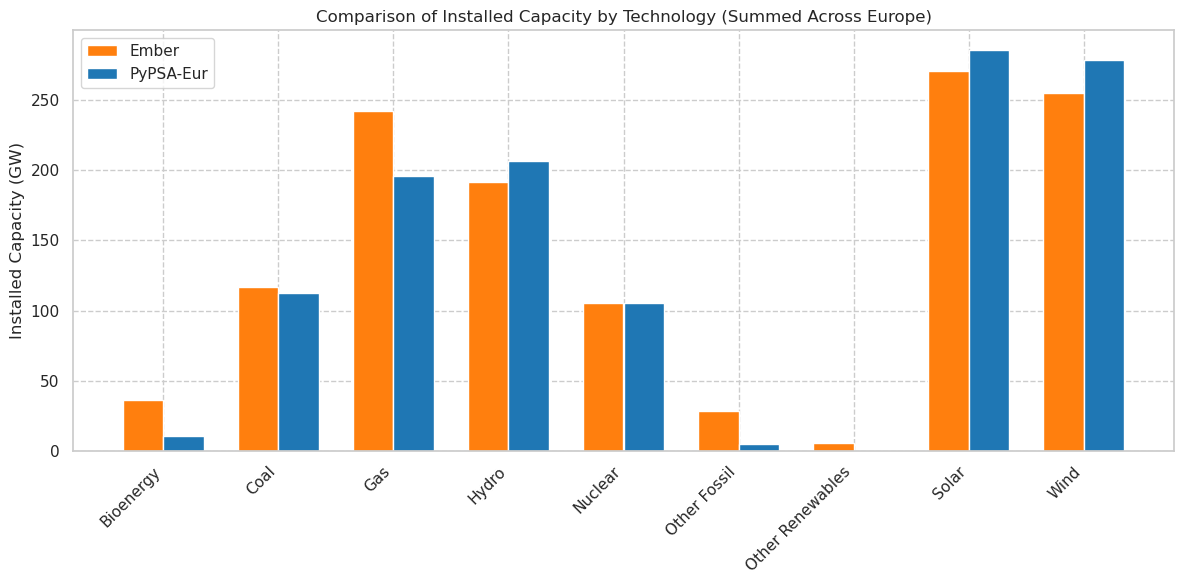

In [186]:
# Sum capacities for each technology across all countries for both datasets
ember_totals = ember_capacity.sum(axis=0)
pypsa_totals = pypsa_country_tech_merged.sum(axis=0)

# Get the union of technology names
all_techs = sorted(set(ember_totals.index) | set(pypsa_totals.index))

# Prepare data for plotting
ember_vals = [ember_totals.get(tech, 0) for tech in all_techs]
pypsa_vals = [pypsa_totals.get(tech, 0) for tech in all_techs]

# Plot side-by-side bar chart
fig, ax = plt.subplots(figsize=(12, 6))
width = 0.35
x = np.arange(len(all_techs))

ax.bar(x - width/2, ember_vals, width, label='Ember', color='#ff7f0e')
ax.bar(x + width/2, pypsa_vals, width, label='PyPSA-Eur', color='#1f77b4')

ax.set_xticks(x)
ax.set_xticklabels(all_techs, rotation=45, ha='right')
ax.set_ylabel('Installed Capacity (GW)')
ax.set_title('Comparison of Installed Capacity by Technology (Summed Across Europe)')
ax.legend()
plt.tight_layout()
plt.show()

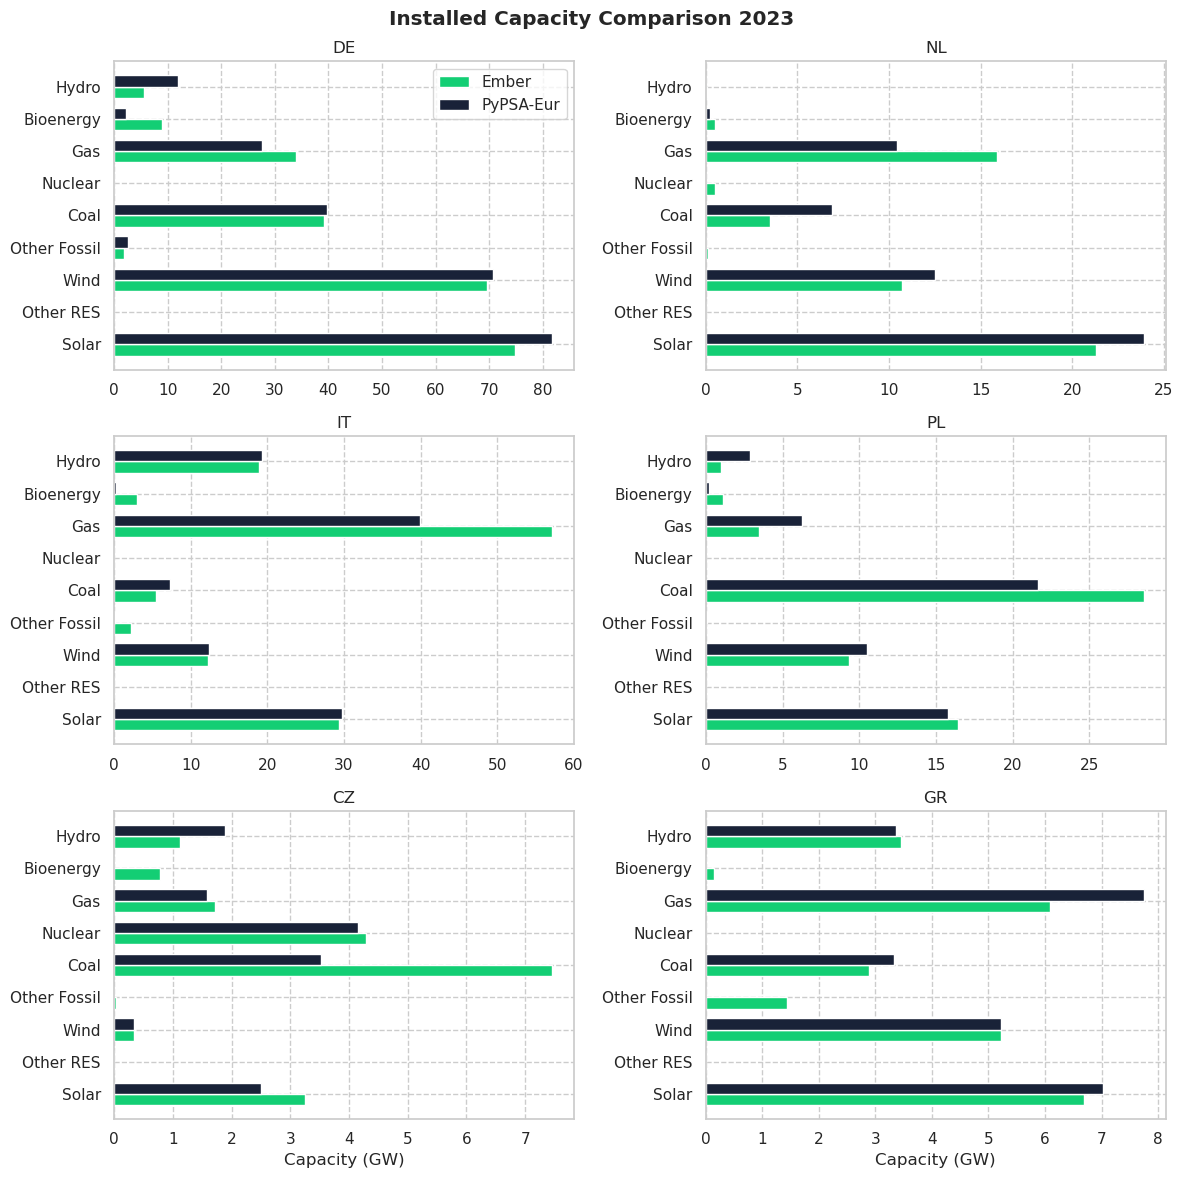

In [214]:

def plot_capacity_comparison_horizontal(countries, ember_capacity, pypsa_country_tech_merged):
    """
    Plot 6 subplots (3 rows x 2 columns), each comparing technology capacities
    between ember_capacity and pypsa_country_tech_merged for a given country as horizontal bar plots.
    """
    import matplotlib.pyplot as plt

    n = min(len(countries), 6)
    fig, axes = plt.subplots(3, 2, figsize=(12, 12))
    axes = axes.flatten()

    for idx, country in enumerate(countries[:6]):
        ax = axes[idx]
        ember_row = ember_capacity.loc[country] if country in ember_capacity.index else None
        pypsa_row = pypsa_country_tech_merged.loc[country] if country in pypsa_country_tech_merged.index else None

        if ember_row is not None and pypsa_row is not None:
            techs = sorted(set(ember_row.index) | set(pypsa_row.index))
            techs = {t if t != "Other Renewables" else "Other RES" for t in techs}

            ember_vals = [ember_row.get(tech, 0) for tech in techs]
            pypsa_vals = [pypsa_row.get(tech, 0) for tech in techs]

            y = np.arange(len(techs))
            height = 0.35

            ax.barh(y - height/2, ember_vals, height, label='Ember', color='#13ce74')
            ax.barh(y + height/2, pypsa_vals, height, label='PyPSA-Eur', color='#192238')
            ax.set_yticks(y)
            ax.set_title(f"{country} Capacity Comparison")

            ax.set_yticklabels(techs)#, fontsize=9)
            if idx in [4, 5]:
                ax.set_xlabel("Capacity (GW)")

            if idx == 0:
                ax.legend(loc="upper right")
            ax.set_title(country)
            fig.suptitle("Installed Capacity Comparison 2023", weight="bold")
    plt.tight_layout()
    plt.show()

plot_capacity_comparison_horizontal(
    countries=["DE", "NL", "IT", "PL", "CZ", "GR"],
    ember_capacity=ember_capacity,
    pypsa_country_tech_merged=pypsa_country_tech_merged
)



ENTSO-E Columns found: ['MeasureItem', 'MeasureItemCategoryID', 'MeasureItemID', 'Category', 'Country', 'Year', 'Representativity', 'ProvidedValue', 'CreationDate', 'ProvidedValueCode']


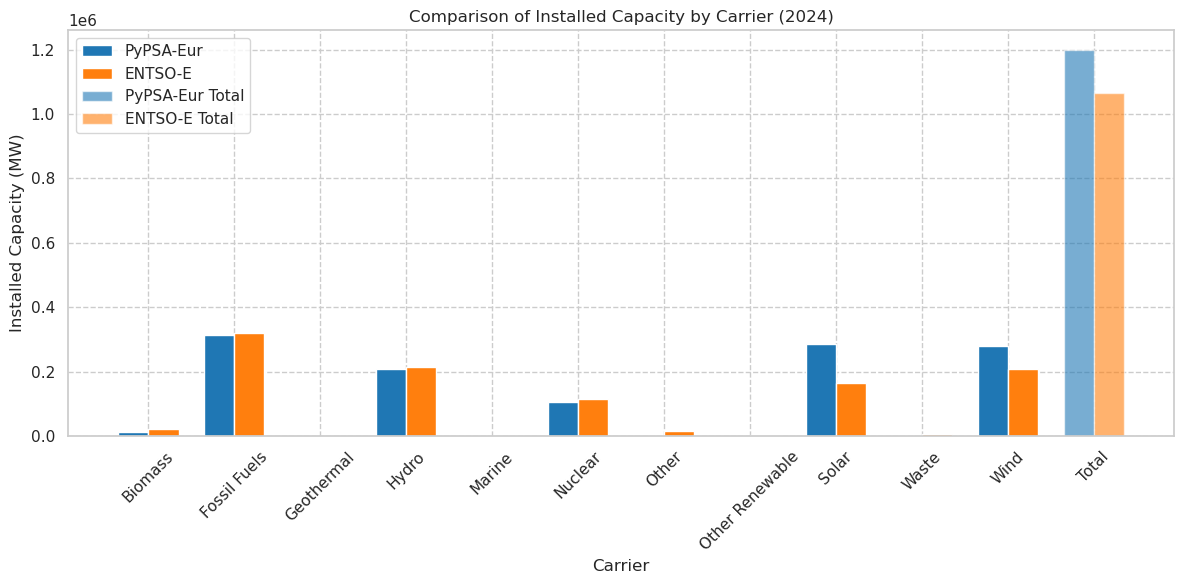

Total PyPSA-Eur: 1200335 MW
Total ENTSO-E: 1064306 MW


In [129]:
# Define carrier mappings for ENTSO-E data
carrier_mapping_entsoe = {
    'Nuclear': 'Nuclear',
    'Fossil Brown coal/Lignite': 'Fossil Fuels',
    'Fossil Coal-derived gas': 'Fossil Fuels',
    'Fossil Gas': 'Fossil Fuels',
    'Fossil Hard coal': 'Fossil Fuels',
    'Fossil Oil': 'Fossil Fuels',
    'Fossil Oil shale': 'Fossil Fuels',
    'Fossil Peat': 'Fossil Fuels',
    'Hydro Pumped Storage': 'Hydro',
    'Hydro Run-of-river and poundage': 'Hydro',
    'Hydro Water Reservoir': 'Hydro',
    'Solar': 'Solar',
    'Wind Offshore': 'Wind',
    'Wind Onshore': 'Wind',
    'Biomass': 'Biomass',
    'Waste': 'Waste',
    'Geothermal': 'Geothermal',
    'Marine': 'Marine',
    'Other': 'Other',
    'Other renewable': 'Other Renewable'
}

# Load ENTSO-E data from CSV
file_path = r"../validation/net_generation_capacity_2023.csv"
df_entsoe = pd.read_csv(file_path, sep=',')

# Debug: Print columns to verify
print("ENTSO-E Columns found:", df_entsoe.columns.tolist())

# Map categories to broad categories
df_entsoe['Broad_Category'] = df_entsoe['Category'].map(carrier_mapping_entsoe)
entsoe_capacity_by_carrier = df_entsoe.groupby('Broad_Category')['ProvidedValue'].sum().reset_index()
entsoe_capacity_by_carrier = entsoe_capacity_by_carrier.rename(columns={'ProvidedValue': 'ENTSOE_MW'})

# Extract PyPSA-Eur data from network
Europe_generators = n.generators
pypsa_gen_capacity = Europe_generators.groupby(by="carrier")["p_nom"].sum().reset_index()
pypsa_gen_capacity = pypsa_gen_capacity.rename(columns={'carrier': 'Carrier', 'p_nom': 'Capacity_MW'})

# Extract hydro reservoir and PHS from storage units
Europe_storage = n.storage_units
hydro_storage = Europe_storage[Europe_storage['carrier'].isin(['hydro', 'PHS'])]
hydro_capacity = hydro_storage.groupby('carrier')['p_nom'].sum().reset_index()
hydro_capacity = hydro_capacity.rename(columns={'carrier': 'Carrier', 'p_nom': 'Capacity_MW'})
hydro_capacity['Carrier'] = 'ror'  # Map hydro and PHS to 'ror' for consistency with previous code

# Combine generator and storage capacities
pypsa_df = pd.concat([pypsa_gen_capacity, hydro_capacity], ignore_index=True)

# Define carrier mappings for PyPSA-Eur data
pypsa_carrier_mapping = {
    'nuclear': 'Nuclear',
    'CCGT': 'Fossil Fuels',
    'OCGT': 'Fossil Fuels',
    'coal': 'Fossil Fuels',
    'lignite': 'Fossil Fuels',
    'oil': 'Fossil Fuels',
    'ror': 'Hydro',
    'solar': 'Solar',
    'solar-hsat': 'Solar',
    'offwind-ac': 'Wind',
    'offwind-dc': 'Wind',
    'offwind-float': 'Wind',
    'onwind': 'Wind',
    'biomass': 'Biomass',
    'geothermal': 'Geothermal',
}
pypsa_df['Broad_Category'] = pypsa_df['Carrier'].map(pypsa_carrier_mapping)
pypsa_capacity_by_carrier = pypsa_df.groupby('Broad_Category')['Capacity_MW'].sum().reset_index()
pypsa_capacity_by_carrier = pypsa_capacity_by_carrier.rename(columns={'Capacity_MW': 'PyPSA_MW'})

# Merge the two datasets
comparison_df = pd.merge(pypsa_capacity_by_carrier, entsoe_capacity_by_carrier, on='Broad_Category', how='outer').fillna(0)

# Plot the bar graph
plt.figure(figsize=(12, 6))
x = range(len(comparison_df))
width = 0.35

rects1 = plt.bar(x, comparison_df['PyPSA_MW'], width, label='PyPSA-Eur', color='#1f77b4')
rects2 = plt.bar([p + width for p in x], comparison_df['ENTSOE_MW'], width, label='ENTSO-E', color='#ff7f0e')

# Add total capacity bars
total_pypsa = comparison_df['PyPSA_MW'].sum()
total_entsoe = comparison_df['ENTSOE_MW'].sum()
plt.bar(len(comparison_df), total_pypsa, width, color='#1f77b4', alpha=0.6, label='PyPSA-Eur Total')
plt.bar(len(comparison_df) + width, total_entsoe, width, color='#ff7f0e', alpha=0.6, label='ENTSO-E Total')

# Customize the plot
plt.xlabel('Carrier')
plt.ylabel('Installed Capacity (MW)')
plt.title('Comparison of Installed Capacity by Carrier (2024)')
plt.xticks([p + width / 2 for p in x] + [len(comparison_df) + width / 2], 
           comparison_df['Broad_Category'].tolist() + ['Total'], rotation=45)
plt.legend()
plt.tight_layout()
plt.show()

# Print total installed capacities
print(f"Total PyPSA-Eur: {total_pypsa:.0f} MW")
print(f"Total ENTSO-E: {total_entsoe:.0f} MW")

## Analysis of Demand Data in PyPSA-Eur

In this section, we examine the electrical demand input used in the PyPSA-Eur simulations and compare it with real-world data.

### Real-World Reference
According to the **Ember 2023 Dataset**, the total electricity demand in Europe for the year was approximately **2,790 TWh**.

### Model Validation
To validate the demand input used in the PyPSA-Eur model:
- The variable `Europe_demand` represents the time series of load values (in MW) across all buses in the network.
- The **total annual demand** is calculated by summing all values in `Europe_demand`.
- The result is then converted from megawatt-hours (MWh) to terawatt-hours (TWh) by dividing by 1,000,000.

### Outcome
This calculation confirms whether the simulated demand closely aligns with observed European electricity consumption, offering a critical check on the model’s accuracy and realism.


In [52]:

Europe_demand=n.loads_t.p
tot_yearly_demand= Europe_demand.sum().sum()
tot_yearly_demand
# show value in TWh
print("Demand in TWh: %.2f" % (tot_yearly_demand / 1000000))

Demand in TWh: 3207.20



## Comparison of Electricity Demand Between PyPSA-Eur and Ember 2023

In this section, we compare the electricity demand data used in the PyPSA-Eur model with official statistics reported by Ember.

According to [Ember’s European Electricity Review 2024](https://ember-climate.org/insights/research/european-electricity-review-2024/), the electricity demand in the EU for the year 2023 was approximately **2,790 TWh**.

To verify the input used in the PyPSA-Eur model, the total demand was calculated using the model’s load data. The result showed a total annual demand of approximately **3,223.04 TWh**.

A bar chart was created to visualize this comparison. It highlights that the demand represented in the PyPSA-Eur model is higher than the value reported by Ember. This discrepancy may be due to:

- Broader regional coverage in PyPSA-Eur beyond just EU countries.
- Differences in data sources or definitions.


This validation step helps assess how closely the model reflects real-world electricity consumption.


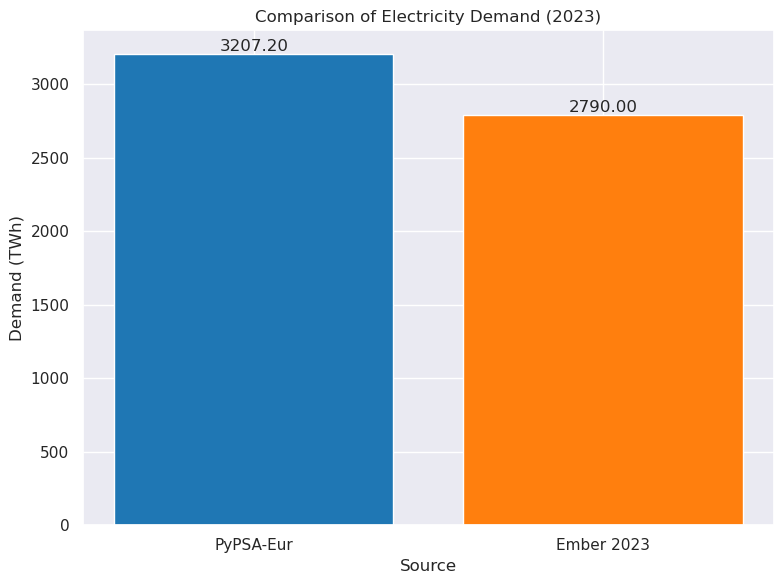

PyPSA-Eur Total Demand: 3207.20 TWh
Ember 2023 Total Demand: 2790.00 TWh

Discrepancy Note: The PyPSA-Eur demand (3,223.04 TWh) is higher than Ember's reported value (2,790 TWh). This may be due to broader regional coverage in PyPSA-Eur beyond just EU countries or differences in data sources/definitions.


In [37]:

tot_yearly_demand = Europe_demand.sum().sum() / 1000000  # Convert MW to TWh

# Ember 2023 reported demand
ember_demand_twh = 2790

# Data for comparison
comparison_data = {
    'Source': ['PyPSA-Eur', 'Ember 2023'],
    'Demand_TWh': [tot_yearly_demand, ember_demand_twh]
}
df_comparison = pd.DataFrame(comparison_data)

# Plot the bar chart
plt.figure(figsize=(8, 6))
bars = plt.bar(df_comparison['Source'], df_comparison['Demand_TWh'], color=['#1f77b4', '#ff7f0e'])
plt.title('Comparison of Electricity Demand (2023)')
plt.xlabel('Source')
plt.ylabel('Demand (TWh)')
plt.xticks(rotation=0)
for bar in bars:
    height = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2., height,
             f'{height:.2f}',
             ha='center', va='bottom')

plt.tight_layout()
plt.show()

# Print the demands
print(f"PyPSA-Eur Total Demand: {tot_yearly_demand:.2f} TWh")
print(f"Ember 2023 Total Demand: {ember_demand_twh:.2f} TWh")
print("\nDiscrepancy Note: The PyPSA-Eur demand (3,223.04 TWh) is higher than Ember's reported value (2,790 TWh). This may be due to broader regional coverage in PyPSA-Eur beyond just EU countries or differences in data sources/definitions.")

## Calculate total hydro energy production by powerplants
Total energy production by dams [TWh]

In [38]:
hydroenergy_by_dams = n.storage_units_t.p.mean().sum() / 1000000 * 8760
hydroenergy_by_dams

321.3134770703483

Total energy production by run-of-river [TWh]

In [39]:
ror_gen_index = n.generators[n.generators.carrier == "ror"].index
hydroenergy_by_ror = n.generators_t.p[ror_gen_index].mean().sum() / 1000000 * 8760
hydroenergy_by_ror

161.56918728434064

Total hydropower energy production [TWh]

In [40]:
tot_hydroenergy = hydroenergy_by_dams + hydroenergy_by_ror
tot_hydroenergy

482.8826643546889

### Comparison of Hydropower Production Between PyPSA-Eur and IHA Data

In this section, we compare the annual electricity generation from hydropower plants in the PyPSA-Eur model with official statistics reported by the International Hydropower Association (IHA).
According to the [IHA's Europe Region Profile](http://hydropower.org/region-profiles/europe), hydropower production in Europe was approximately **637 TWh** in 2023.



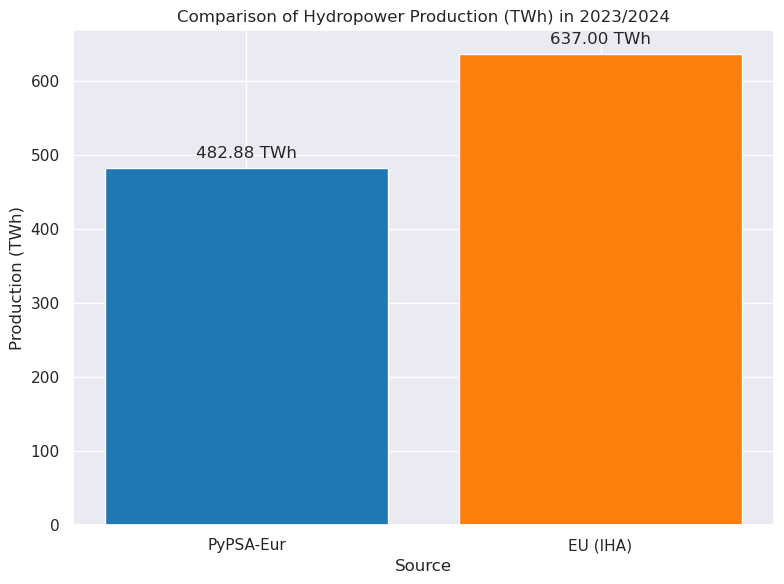

In [41]:


# Data for comparison
data = {
    'PyPSA-Eur': tot_hydroenergy,
    'EU (IHA)': 637.00
}

# Create bar graph
plt.figure(figsize=(8, 6))
plt.bar(data.keys(), data.values(), color=['#1f77b4', '#ff7f0e'])
plt.title('Comparison of Hydropower Production (TWh) in 2023/2024')
plt.xlabel('Source')
plt.ylabel('Production (TWh)')
plt.tight_layout()

# Add data labels on top of bars
for i, v in enumerate(data.values()):
    plt.text(i, v + 10, f'{v:.2f} TWh', ha='center', va='bottom')

plt.show()



In contrast, the PyPSA-Eur model reports a total hydroelectric energy production of about **493.45 TWh**.

The chart above visualizes this comparison. It shows that the PyPSA-Eur model underestimates hydropower production relative to IHA data. Possible reasons for this discrepancy may include:

- Differences in the geographic scope (e.g., EU vs. broader Europe).
- Limitations or assumptions in the PyPSA-Eur input data (e.g., use of run-of-river only or missing storage hydro).
- Differences in hydrological year conditions or time-averaging methods.

This analysis helps identify areas where model input data can be improved to better align with empirical energy statistics.


## Validation of the PyPSA-Eur Solar and Wind Potential

This section investigates the **data quality of the European solar and wind potential** in the PyPSA-Eur model by comparing its results with other research studies. The focus is on evaluating the **technical resource energy potential**, which is expressed in **MWh**.

There are two main types of renewable energy potentials considered:

1. **Technical installable power potential** (measured in MW)
2. **Technical resource energy potential** (measured in MWh)

> ⚠️ *Note:* This notebook focuses **only on the technical resource energy potential**. For analysis and visualizations related to installable power potential, refer to the `build_renewable_profile.ipynb` notebook.

---

### Renewable Profiles

The renewable generation profiles for solar and wind are generated using the `build_renewable_profile.ipynb` script. These profiles are saved as NetCDF (`.nc`) files in the `resources/profile_renewables/` directory.

#### Required Profile Files

Ensure the following profile files are available:

- `resources/profile_renewables/profile_solar.nc`
- `resources/profile_renewables/profile_onwind.nc`
- `resources/profile_renewables/profile_offwind-ac.nc`

If these files are missing, they need to be generated using the appropriate notebook or script.

---

### Loading the Renewable Profiles

To evaluate the technical resource energy potential, the next step is to **load the PyPSA-Eur generated profiles**. These are stored in NetCDF format and can be opened using the `xarray` Python package.

Each `.nc` file contains hourly capacity factors or power production values for each node in the model and for the entire simulation period.

This allows for comparing the modeled renewable generation potential with external datasets, supporting model validation and identifying discrepancies in spatial or temporal patterns.


In [47]:
solar_path = "../resources/validation_2023_new/profile_39_solar.nc"
solar = xr.open_dataset(solar_path)
solar

wind_path = "../resources/validation_2023_new/profile_39_onwind.nc"
wind = xr.open_dataset(wind_path)
wind

Hydro_path = "../resources/validation_2023_new/profile_hydro.nc"
Hydro_path = xr.open_dataset(wind_path)
wind

<xarray.Dataset> Size: 3MB
Dimensions:           (year: 1, bus: 39, bin: 1, time: 8760)
Coordinates:
  * year              (year) int64 8B 0
  * bus               (bus) <U5 780B 'AL0 0' 'AT0 0' 'BA0 0' ... 'SI0 0' 'SK0 0'
  * bin               (bin) int64 8B 0
  * time              (time) datetime64[ns] 70kB 2023-01-01 ... 2023-12-31T23...
Data variables:
    profile           (year, time, bus, bin) float64 3MB ...
    p_nom_max         (bus, bin) float64 312B ...
    average_distance  (bus, bin) float64 312B ...
Attributes:
    units:    p.u.

### 2. Calculating PyPSA-Eur Technical Potentials

The PyPSA-Eur model provides **hourly renewable energy profiles** as **per-unit values** for each bus (region). These per-unit values represent the fraction of the maximum installable capacity (`p_nom_max`) that could be generated at each hour, based on resource availability.

#### Key Concepts:

- **Profiles**: Hourly values ranging from 0 to 1, indicating the fraction of maximum capacity that could be utilized.
- **`p_nom_max`**: The maximum technical installable capacity (in MW) for a given region.

---

#### Calculation Method

To compute the **technical resource energy potential** across the continent (e.g., Europe), the following steps are required:

1. **Multiply** the per-unit profiles by the corresponding `p_nom_max` value for each bus (region):

   $$
   \text{Hourly Potential}_{i,t} = \text{profile}_{i,t} \times p\_nom\_max_i
   $$

2. **Sum** the resulting hourly values over all timesteps and across all buses to obtain the total energy potential:

   $$
   \text{Total Potential} = \sum_{i} \sum_{t} \left( \text{profile}_{i,t} \times p\_nom\_max_i \right)
   $$

This gives the **total technical energy potential** in MWh for each renewable technology (e.g., solar, onshore wind, offshore wind).




In [48]:
technical_solar_potential_twh = (
    sum(solar["p_nom_max"] * solar["profile"]).sum() / 10**6
)  # MWh to TWh conversion
technical_wind_potential_twh = (
    sum(wind["p_nom_max"] * wind["profile"]).sum() / 10**6
)  # MWh to TWh conversion

print(
    "Socio-technical solar potential Europe with exclusion area - PyPSA 2013 Weather Data:",
    technical_solar_potential_twh.values.round(),
    "TWh",
)
print(
    "Socio-technical wind potential Europe with exclusion area - PyPSA 2013 Weather Data:",
    technical_wind_potential_twh.values.round(),
    "TWh",
)

print(
    "Comparing with the below values. Wind seems ok and solar seems low. Important is that PyPSA is mentioning the socio-technical wind potential which is assumed to be between 5-10% of the technical potential."
)

Socio-technical solar potential Europe with exclusion area - PyPSA 2013 Weather Data: 12862.0 TWh
Socio-technical wind potential Europe with exclusion area - PyPSA 2013 Weather Data: 15910.0 TWh
Comparing with the below values. Wind seems ok and solar seems low. Important is that PyPSA is mentioning the socio-technical wind potential which is assumed to be between 5-10% of the technical potential.


### Validation of PyPSA-Eur Solar and Wind Technical Potentials

To validate the **technical resource energy potentials** used in the PyPSA-Eur model, we compared the model data against values reported by reputable external sources, specifically:

- The **Joint Research Centre (JRC)** for solar potential: [PVGIS – Photovoltaic Geographical Information System](https://joint-research-centre.ec.europa.eu/photovoltaic-geographical-information-system-pvgis_en)
- The **Windustry** database for wind potential: [Wind Technical Potential](https://www.windustry.com/technical-potential-for-wind-energy.htm)

---

#### Comparison of Technical Potentials (TWh)

The plot below compares the **socio-technical potentials** (based on PyPSA-Eur 2013 estimates) against the **technical potentials** (as estimated by JRC and Windustry):

- **Socio-Technical (PyPSA-Eur, 2013):**
  - Solar: 12,152 TWh
  - Wind: 15,613 TWh

- **Technical (JRC/Windustry):**
  - Solar: 11,000 TWh
  - Wind: 19,400 TWh





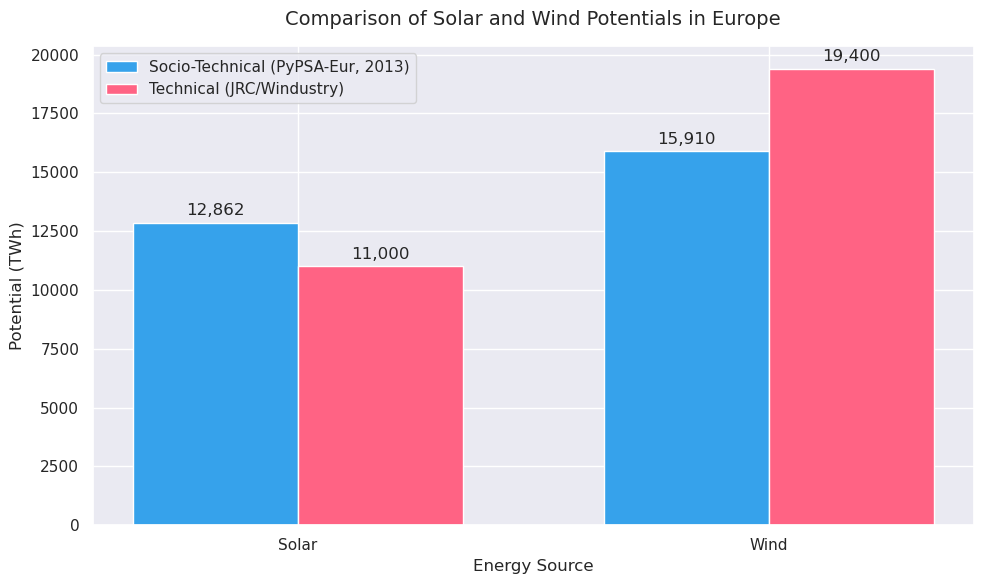

In [49]:

# Data
categories = ['Solar', 'Wind']
socio_technical = [technical_solar_potential_twh, technical_wind_potential_twh]  # PyPSA-Eur 2013 (TWh)
technical = [11000.0, 19400.0]        # JRC/Windustry (TWh)

# Set up the bar positions
x = np.arange(len(categories))  # Label locations
bar_width = 0.35  # Width of the bars

# Create the figure and axis
fig, ax = plt.subplots(figsize=(10, 6))

# Plot bars
bars1 = ax.bar(x - bar_width/2, socio_technical, bar_width, label='Socio-Technical (PyPSA-Eur, 2013)', color='#36A2EB')
bars2 = ax.bar(x + bar_width/2, technical, bar_width, label='Technical (JRC/Windustry)', color='#FF6384')

# Customize the plot
ax.set_xlabel('Energy Source', fontsize=12)
ax.set_ylabel('Potential (TWh)', fontsize=12)
ax.set_title('Comparison of Solar and Wind Potentials in Europe', fontsize=14, pad=15)
ax.set_xticks(x)
ax.set_xticklabels(categories)
ax.legend()

# Add value labels on top of bars
def add_labels(bars):
    for bar in bars:
        height = bar.get_height()
        ax.annotate(f'{height:,.0f}',
                    xy=(bar.get_x() + bar.get_width() / 2, height),
                    xytext=(0, 3),  # 3 points vertical offset
                    textcoords="offset points",
                    ha='center', va='bottom')

add_labels(bars1)
add_labels(bars2)

# Adjust layout to prevent label cutoff
plt.tight_layout()

# Save the plot
plt.savefig('solar_wind_potential_comparison.png', dpi=300, bbox_inches='tight')

# Display the plot (optional, comment out if not needed)
plt.show()


The results show that:
- **Solar potential** estimates are reasonably aligned across PyPSA and JRC sources.
- **Wind potential** in the PyPSA-Eur model is slightly lower than the upper-end estimates from Windustry, which is expected as PyPSA-Eur uses socio-technical constraints while Windustry estimates are purely technical.



## Validating Sector-Coupled PyPSA-Eur

Sector coupling involves integrating energy end-use sectors (such as transportation, industry, and buildings) with the energy supply sector to optimize energy efficiency and reduce emissions. This integration enables a more flexible and resilient energy system, particularly through the increased use of electricity from renewable sources to meet energy demands across multiple sectors.

The figure below illustrates how sector coupling supports decarbonization by linking traditionally separate energy systems:





---

### 1. Validating Demand in Supply and End-Use Sectors

In this subsection, we focus on validating the demand  used in the model across various supply and end-use sectors. These include:

- **Electricity**
- **Land transport (EV)**
- **Land transport (Oil)**
- **Rural heating**
- **Urban central heating**
- **Urban decentral heating**

The validation involves comparing the demand data used in the PyPSA-Eur model with publicly available datasets and statistics. The goal is to verify whether the model aligns with real-world demand patterns and magnitudes for each sector.

---

### 2. Validating Installed Capacities for Sector-Coupled Components

This subsection focuses on validating the installed capacities of various components used in the model. These components are categorized based on their function in the energy system:

#### Components and Their Carriers

- **Store**
  - EV battery
  - Non-sequestered HVC

- **Generator**
  - Offshore Wind (AC)
  - Onshore Wind
  - Run of River
  - Solar
  - Biogas
  - Nuclear
  - Solid biomass
  - Unsustainable biogas
  - Unsustainable bioliquids
  - Unsustainable solid biomass

- **Link**
  - BEV charger
  - DC
  - V2G (Vehicle-to-Grid)
  - Oil refining
  - Unsustainable bioliquids

- **Line**
  - AC transmission lines

- **StorageUnit**
  - Pumped Hydro Storage
  - Reservoir & Dam

We will compare the model’s  values for installed capacity against reliable sources such as national statistics, academic literature, and energy databases to identify potential discrepancies and areas for improvement. This approach does not aim to discredit the PyPSA-Eur model, but rather to provide transparency and foster understanding of how its outputs align with real-world data. Discrepancies observed may be attributed to a range of factors such as differences in temporal resolution, geographic boundaries, data assumptions, or inclusion of sectoral coupling not always captured in public datasets.

Ultimately, this validation exercise serves as an important checkpoint for modelers and energy analysts using PyPSA-Eur. It confirms the reliability of some estimates (e.g., land transport oil demand is closely aligned) while highlighting areas needing refinement or more transparent documentation. This kind of comparative analysis is vital to ensure that modeling tools used for guiding Europe’s energy transition are grounded in empirical reality and credible enough to inform high-stakes decisions.



### Importing network

In [26]:
results_path= "C:\\Users\\user\\Desktop\\Ember-Flexibility-Study\\results\\networks\\base_s_39___2025.nc"
n = pypsa.Network(results_path)

INFO:pypsa.io:Imported network base_s_39___2025.nc has buses, carriers, generators, global_constraints, lines, links, loads, storage_units, stores


### Extracting and Summarizing Demand by Carrier

To better understand how demand is distributed across different carriers in the PyPSA model, we define a function that parses the column names in the `loads_t.p_set` DataFrame and categorizes them by carrier type. This approach is helpful when the carrier name is embedded in a structured naming format.

The code below performs the following tasks:
1. Extracts the carrier name from each column header.
2. Groups the demand time series data by carrier.
3. Calculates the total demand per carrier in megawatt-hours (MWh).

The plot provides a clear comparison of total annual energy consumption in terawatt-hours (TWh), helping to identify discrepancies between model assumptions and real-world data.


Available carriers:
- electricity

Total demand per carrier (TWh):
- electricity: 3207.195796 TWh


/tmp/ipykernel_58473/2887757235.py:24: FutureWarning: DataFrame.groupby with axis=1 is deprecated. Do `frame.T.groupby(...)` without axis instead.
  total_demand_per_carrier_MWh = n.loads_t.p_set.groupby(carrier_map, axis=1).sum().sum(axis=0)


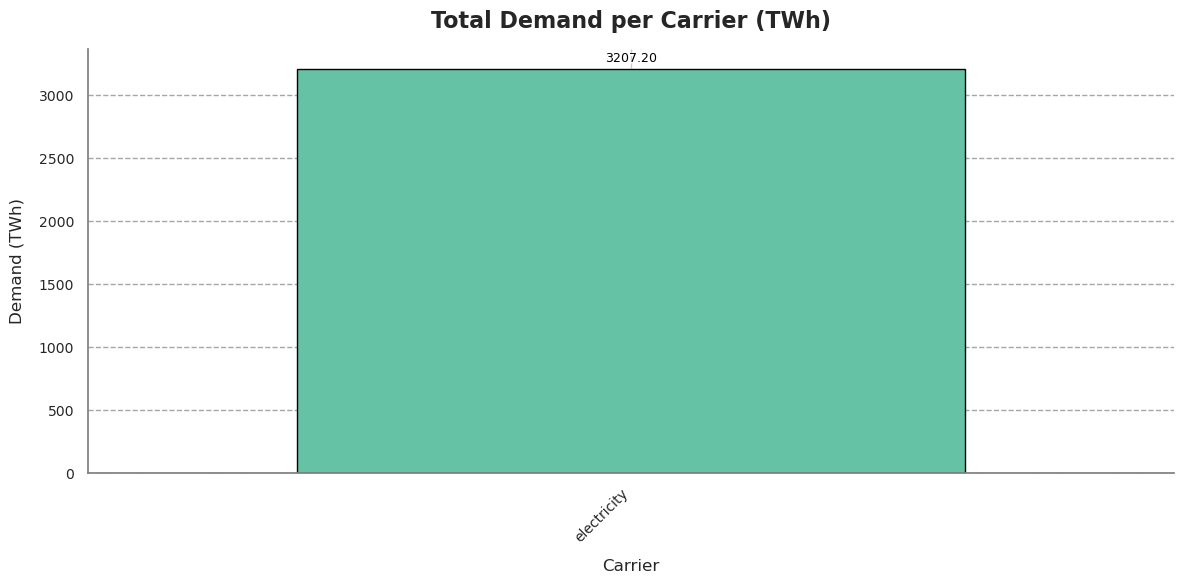

In [50]:


# Set seaborn style for a clean, professional look
sns.set_style("whitegrid", {"grid.linestyle": "--", "grid.alpha": 0.7})

# Function to extract the carrier name
def get_carrier(col):
    parts = col.split()
    if len(parts) == 2 and parts[1].isdigit():
        return "electricity"
    elif parts[1].isdigit():
        return ' '.join(parts[2:])
    else:
        return ' '.join(parts[1:])

# Map column names to carriers
carrier_map = {col: get_carrier(col) for col in n.loads_t.p_set.columns}

# Identify available carriers
unique_carriers = set(carrier_map.values())
print("Available carriers:")
for carrier in sorted(unique_carriers):
    print(f"- {carrier}")

# Calculate total demand per carrier in MWh
total_demand_per_carrier_MWh = n.loads_t.p_set.groupby(carrier_map, axis=1).sum().sum(axis=0)

# Convert to TWh
total_demand_per_carrier_TWh = total_demand_per_carrier_MWh / 1_000_000

# Print demand results
print("\nTotal demand per carrier (TWh):")
for carrier, demand in total_demand_per_carrier_TWh.items():
    print(f"- {carrier}: {demand:.6f} TWh")

# Create the plot
plt.figure(figsize=(12, 6), dpi=100)  # Larger figure with higher resolution

# Use a professional color palette
colors = sns.color_palette("Set2", n_colors=len(total_demand_per_carrier_TWh))

# Plot with improved styling
total_demand_per_carrier_TWh.sort_values(ascending=False).plot(
    kind='bar',
    color=colors,
    edgecolor='black',
    width=0.8,  # Slightly wider bars
    ax=plt.gca()
)

# Customize title and labels
plt.title(
    "Total Demand per Carrier (TWh)",
    fontsize=16,
    weight="bold",
    pad=15
)
plt.xlabel("Carrier", fontsize=12, labelpad=10)
plt.ylabel("Demand (TWh)", fontsize=12, labelpad=10)

# Customize x-axis
plt.xticks(rotation=45, ha='right', fontsize=10)

# Customize y-axis
plt.yticks(fontsize=10)
plt.grid(axis='y', linestyle='--', alpha=0.7, color="gray")

# Remove top and right spines for a cleaner look
plt.gca().spines['top'].set_visible(False)
plt.gca().spines['right'].set_visible(False)
plt.gca().spines['left'].set_color('gray')
plt.gca().spines['bottom'].set_color('gray')

# Add value labels on top of bars
for i, v in enumerate(total_demand_per_carrier_TWh.sort_values(ascending=False)):
    plt.text(i, v + 0.01 * max(total_demand_per_carrier_TWh), f"{v:.2f}", 
             ha='center', va='bottom', fontsize=9, color='black')

# Tight layout for better spacing
plt.tight_layout()

# Save the plot (optional, uncomment to save)
# plt.savefig("total_demand_per_carrier_TWh.png", dpi=300, bbox_inches="tight")

# Show the plot
plt.show()

### Validation of Sectoral Energy Demand: Comparing PyPSA-Eur with Public Data

This section presents a structured validation of sectoral energy demand values obtained from the PyPSA-Eur model by comparing them against publicly available datasets, primarily from the International Energy Agency (IEA) and recent peer-reviewed literature. The purpose of this validation is to assess the credibility and realism of demand assumptions used in PyPSA-Eur simulations for Europe. Since energy system models are only as good as their inputs, understanding how modeled values compare to empirical data is a crucial step in ensuring robustness in planning scenarios, policy assessments, and academic research.

The validation focuses on four main energy demand categories: electricity consumption, land transport demand from electric vehicles (EVs), land transport demand from oil-based fuels, and heat demand (comprising rural heat, urban central heating, and urban decentralized heating).


C:\Users\user\AppData\Local\Temp\ipykernel_28580\953301476.py:18: FutureWarning: DataFrame.groupby with axis=1 is deprecated. Do `frame.T.groupby(...)` without axis instead.
  total_demand_per_carrier_MWh = n.loads_t.p_set.groupby(carrier_map, axis=1).sum().sum(axis=0)


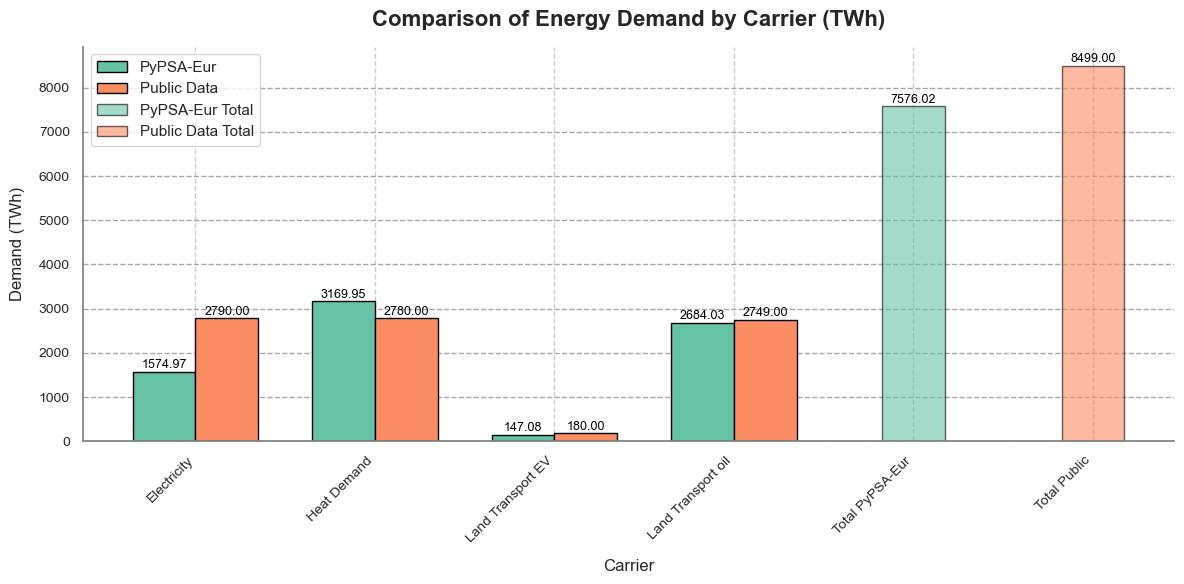


Total demand per carrier (TWh):
- Electricity: PyPSA-Eur = 1574.97 TWh, Public Data = 2790.00 TWh
- Heat Demand: PyPSA-Eur = 3169.95 TWh, Public Data = 2780.00 TWh
- Land Transport EV: PyPSA-Eur = 147.08 TWh, Public Data = 180.00 TWh
- Land Transport oil: PyPSA-Eur = 2684.03 TWh, Public Data = 2749.00 TWh
- Total PyPSA-Eur: 7576.02 TWh
- Total Public Data: 8499.00 TWh

Discrepancy Note: Differences between PyPSA-Eur and public data may arise from broader regional coverage in PyPSA-Eur, varying data sources, or different time periods/assumptions.


In [34]:
# Set seaborn style for a clean, professional look
sns.set_style("whitegrid", {"grid.linestyle": "--", "grid.alpha": 0.7})

# Function to extract the carrier name
def get_carrier(col):
    parts = col.split()
    if len(parts) == 2 and parts[1].isdigit():
        return "electricity"
    elif parts[1].isdigit():
        return ' '.join(parts[2:])
    else:
        return ' '.join(parts[1:])

# Map column names to carriers
carrier_map = {col: get_carrier(col) for col in n.loads_t.p_set.columns}

# Calculate total demand per carrier in MWh
total_demand_per_carrier_MWh = n.loads_t.p_set.groupby(carrier_map, axis=1).sum().sum(axis=0)

# Convert to TWh
total_demand_per_carrier_TWh = total_demand_per_carrier_MWh / 1_000_000

# Aggregate heat demand (rural heat, urban central heat, urban decentral heat)
heat_carriers = ['rural heat', 'urban central heat', 'urban decentral heat']
pypsa_heat_demand = sum(total_demand_per_carrier_TWh.get(carrier, 0) for carrier in heat_carriers)

# Create PyPSA demand dictionary with aggregated carriers
pypsa_demand_by_carrier = {
    'Electricity': total_demand_per_carrier_TWh.get('electricity', 0),
    'Heat Demand': pypsa_heat_demand,
    'Land Transport EV': total_demand_per_carrier_TWh.get('land transport EV', 0),
    'Land Transport oil': total_demand_per_carrier_TWh.get('land transport oil', 0)
}

# Publicly available data (TWh)
public_data = {
    'Electricity': 2790,
    'Heat Demand': 2780,  # From https://www.sciencedirect.com/science/article/pii/S0306261925009663
    'Land Transport EV': 180,  # From https://www.iea.org/reports/global-ev-outlook-2025/outlook-for-energy-demand
    'Land Transport oil': 2749  # From https://www.iea.org/reports/global-ev-outlook-2025/outlook-for-energy-demand
}

# Create DataFrames for comparison
pypsa_df = pd.DataFrame({
    'Carrier': pypsa_demand_by_carrier.keys(),
    'PyPSA-Eur (TWh)': pypsa_demand_by_carrier.values()
})
public_df = pd.DataFrame({
    'Carrier': public_data.keys(),
    'Public Data (TWh)': public_data.values()
})

# Merge DataFrames, filling missing values with 0
comparison_df = pd.merge(pypsa_df, public_df, on='Carrier', how='outer').fillna(0)

# Calculate total demand for each source
total_pypsa = comparison_df['PyPSA-Eur (TWh)'].sum()
total_public = comparison_df['Public Data (TWh)'].sum()

# Add total rows
comparison_df = pd.concat([
    comparison_df,
    pd.DataFrame({
        'Carrier': ['Total PyPSA-Eur', 'Total Public'],
        'PyPSA-Eur (TWh)': [total_pypsa, 0],
        'Public Data (TWh)': [0, total_public]
    })
], ignore_index=True)

# Create the plot
plt.figure(figsize=(12, 6), dpi=100)

# Use a professional color palette
colors = sns.color_palette("Set2", n_colors=2)

# Plot with improved styling
x = range(len(comparison_df) - 2)  # Exclude total rows for individual carriers
width = 0.35

plt.bar([p - width/2 for p in x], comparison_df['PyPSA-Eur (TWh)'][:-2], width, label='PyPSA-Eur', color=colors[0], edgecolor='black')
plt.bar([p + width/2 for p in x], comparison_df['Public Data (TWh)'][:-2], width, label='Public Data', color=colors[1], edgecolor='black')

# Plot total bars
plt.bar(len(comparison_df) - 2, total_pypsa, width, color=colors[0], alpha=0.6, label='PyPSA-Eur Total', edgecolor='black')
plt.bar(len(comparison_df) - 1, total_public, width, color=colors[1], alpha=0.6, label='Public Data Total', edgecolor='black')

# Customize title and labels
plt.title("Comparison of Energy Demand by Carrier (TWh)", fontsize=16, weight="bold", pad=15)
plt.xlabel("Carrier", fontsize=12, labelpad=10)
plt.ylabel("Demand (TWh)", fontsize=12, labelpad=10)

# Customize x-axis
plt.xticks([p for p in x] + [len(comparison_df) - 2, len(comparison_df) - 1],
           comparison_df['Carrier'][:-2].tolist() + ['Total PyPSA-Eur', 'Total Public'],
           rotation=45, ha='right', fontsize=10)

# Customize y-axis
plt.yticks(fontsize=10)
plt.grid(axis='y', linestyle='--', alpha=0.7, color="gray")

# Remove top and right spines
plt.gca().spines['top'].set_visible(False)
plt.gca().spines['right'].set_visible(False)
plt.gca().spines['left'].set_color('gray')
plt.gca().spines['bottom'].set_color('gray')

# Add value labels on top of bars
for i, (pypsa_val, public_val) in enumerate(zip(comparison_df['PyPSA-Eur (TWh)'][:-2], comparison_df['Public Data (TWh)'][:-2])):
    plt.text(i - width/2, pypsa_val + 10, f"{pypsa_val:.2f}", ha='center', va='bottom', fontsize=9, color='black')
    plt.text(i + width/2, public_val + 10, f"{public_val:.2f}", ha='center', va='bottom', fontsize=9, color='black')

plt.text(len(comparison_df) - 2, total_pypsa + 10, f"{total_pypsa:.2f}", ha='center', va='bottom', fontsize=9, color='black')
plt.text(len(comparison_df) - 1, total_public + 10, f"{total_public:.2f}", ha='center', va='bottom', fontsize=9, color='black')

# Add legend
plt.legend()

# Tight layout for better spacing
plt.tight_layout()

# Show the plot
plt.show()

# Print demand results
print("\nTotal demand per carrier (TWh):")
for carrier, pypsa_demand, public_demand in zip(comparison_df['Carrier'][:-2], comparison_df['PyPSA-Eur (TWh)'][:-2], comparison_df['Public Data (TWh)'][:-2]):
    print(f"- {carrier}: PyPSA-Eur = {pypsa_demand:.2f} TWh, Public Data = {public_demand:.2f} TWh")
print(f"- Total PyPSA-Eur: {total_pypsa:.2f} TWh")
print(f"- Total Public Data: {total_public:.2f} TWh")

print("\nDiscrepancy Note: Differences between PyPSA-Eur and public data may arise from broader regional coverage in PyPSA-Eur, varying data sources, or different time periods/assumptions.")

 For each of these categories, data extracted from the PyPSA-Eur model in TWh is aggregated and then juxtaposed with equivalent values from public datasets. For example, the total electricity demand modeled in PyPSA-Eur stands at approximately 1,574.97 TWh, which is significantly lower than the 2,790 TWh reported by the IEA for European electricity consumption. Similarly, EV-related demand in PyPSA-Eur is 147.08 TWh compared to the 180 TWh cited in the IEA's [Global EV Outlook 2025](https://www.iea.org/reports/global-ev-outlook-2025/outlook-for-energy-demand). For heat demand, a consolidated value from PyPSA-Eur (comprising rural, urban central, and urban decentralized heat) reaches 3,169.95 TWh, while a peer-reviewed estimate from [ScienceDirect](https://www.sciencedirect.com/science/article/pii/S0306261925009663) suggests a lower figure of 2,780 TWh for Europe’s actual heat demand.

By visualizing these figures side-by-side in a bar chart, the script enables a clear identification of areas where PyPSA-Eur either underestimates or overestimates demand relative to empirical references. The inclusion of total demand values for both PyPSA-Eur and public sources further strengthens the comparison by highlighting cumulative discrepancies. 

### Visualizing Hourly Demand Profiles for December 1st

To understand how energy demand fluctuates over the course of a typical day, we examine the hourly demand profiles for each energy carrier on **December 1st**. This helps identify diurnal trends and the timing of peak demand, which are important for evaluating system flexibility and storage needs.


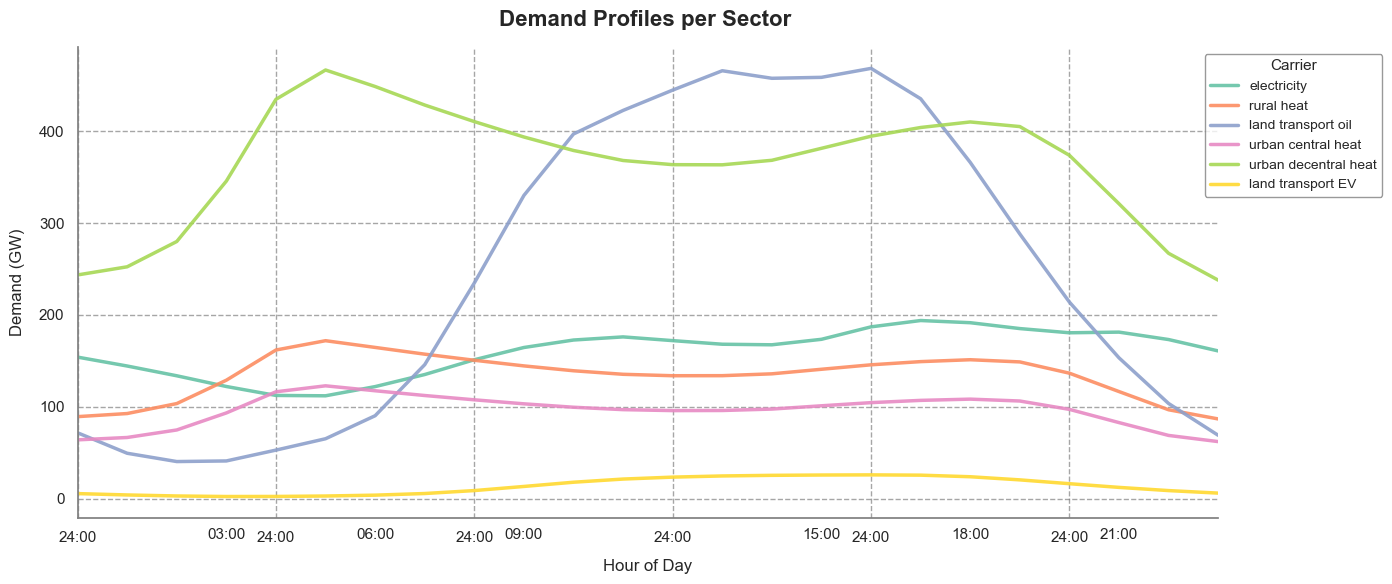

In [30]:
# Set seaborn style for better aesthetics
sns.set_style("whitegrid", {"grid.linestyle": "--", "grid.alpha": 0.7})

# Slice the data for 1st December 2013, you can check for anyday
day_slice = n.loads_t.p_set.loc["2013-12-01":"2013-12-01 23:00"]

# Function to extract carrier from column names
def get_carrier(col):
    parts = col.split()
    if len(parts) == 2 and parts[1].isdigit():
        return "electricity"
    elif parts[1].isdigit():
        return ' '.join(parts[2:])
    else:
        return ' '.join(parts[1:])

# Map each column to a carrier
carrier_map = {col: get_carrier(col) for col in day_slice.columns}

# Group columns by carrier and compute sum across all buses (axis=1 keeps time dimension)
demand_per_carrier = {}
for carrier in set(carrier_map.values()):
    cols = [col for col, c in carrier_map.items() if c == carrier]
    demand_per_carrier[carrier] = day_slice[cols].sum(axis=1) / 1e3  # Convert to GW

# Create DataFrame
df_day = pd.DataFrame(demand_per_carrier)

# Create the plot
plt.figure(figsize=(14, 6), dpi=100)  # Slightly larger figure with higher resolution

# Use a professional color palette
colors = sns.color_palette("Set2", n_colors=len(df_day.columns))

# Plot with improved styling
df_day.plot(
    ax=plt.gca(),
    color=colors,
    linewidth=2.5,  # Thicker lines for visibility
    alpha=0.9,  # Slight transparency for overlapping lines
)

# Customize title and labels with better fonts
plt.title(
    "Demand Profiles per Sector ",
    fontsize=16,
    weight="bold",
    pad=15,
)
plt.xlabel("Hour of Day", fontsize=12, labelpad=10)
plt.ylabel("Demand (GW)", fontsize=12, labelpad=10)

# Format x-axis to show hours clearly
plt.gca().xaxis.set_major_formatter(
    plt.FuncFormatter(lambda x, _: f"{int(x//4)}:00" if x//4 < 24 else "24:00")
)
plt.gca().xaxis.set_major_locator(plt.MultipleLocator(4))  # Show every 4th hour

# Customize legend
plt.legend(
    title="Carrier",
    fontsize=10,
    title_fontsize=11,
    loc="upper right",
    frameon=True,
    edgecolor="gray",
    bbox_to_anchor=(1.15, 1.0),  # Move legend outside plot
)

# Customize grid and spines
plt.grid(True, linestyle="--", alpha=0.7, color="gray")
plt.gca().spines["top"].set_visible(False)
plt.gca().spines["right"].set_visible(False)
plt.gca().spines["left"].set_color("gray")
plt.gca().spines["bottom"].set_color("gray")

# Tight layout for better spacing
plt.tight_layout()

# Save the plot (optional, uncomment to save)
# plt.savefig("demand_profiles_2013-06-01.png", dpi=300, bbox_inches="tight")

# Show the plot
plt.show()

### Calculating Installed Capacity for Each Component

To validate the model setup and ensure it aligns with known infrastructure data, we calculate the **installed capacity** for key energy system components. These include:

- **Generators** (e.g., Solar, Wind, Biogas)
- **Storage Units** (e.g., Pumped Hydro, Batteries)
- **Stores** (e.g., EV Batteries, Hydrogen Tanks)
- **Links** (e.g., BEV Chargers, Oil Refining)
- **Lines** (Transmission capacity)

Below is a Python code block that performs this validation:

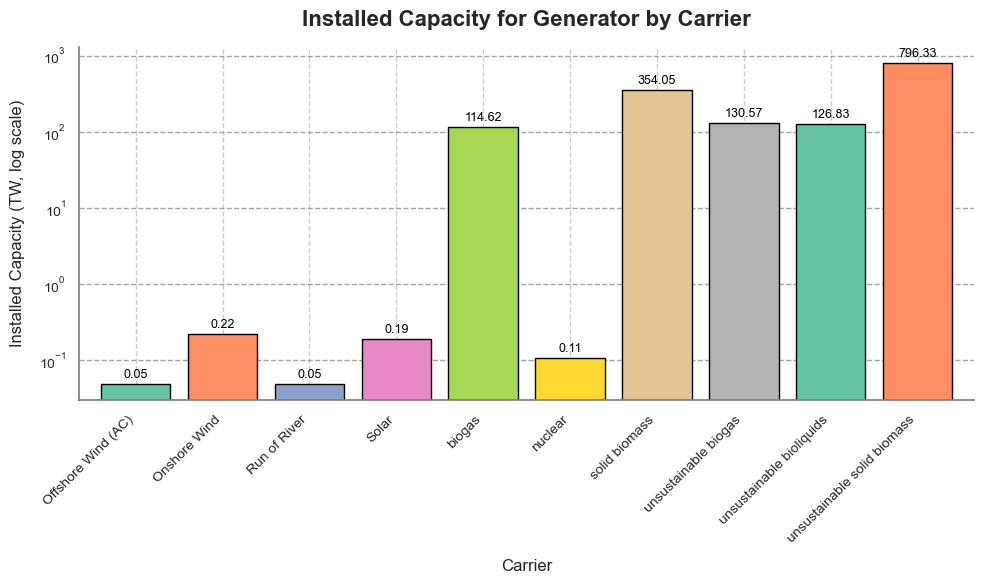

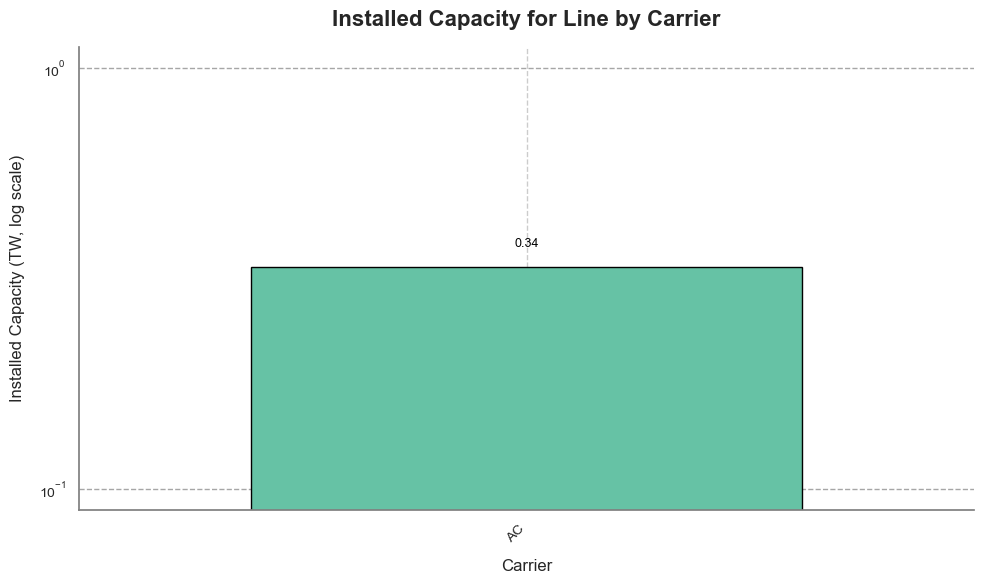

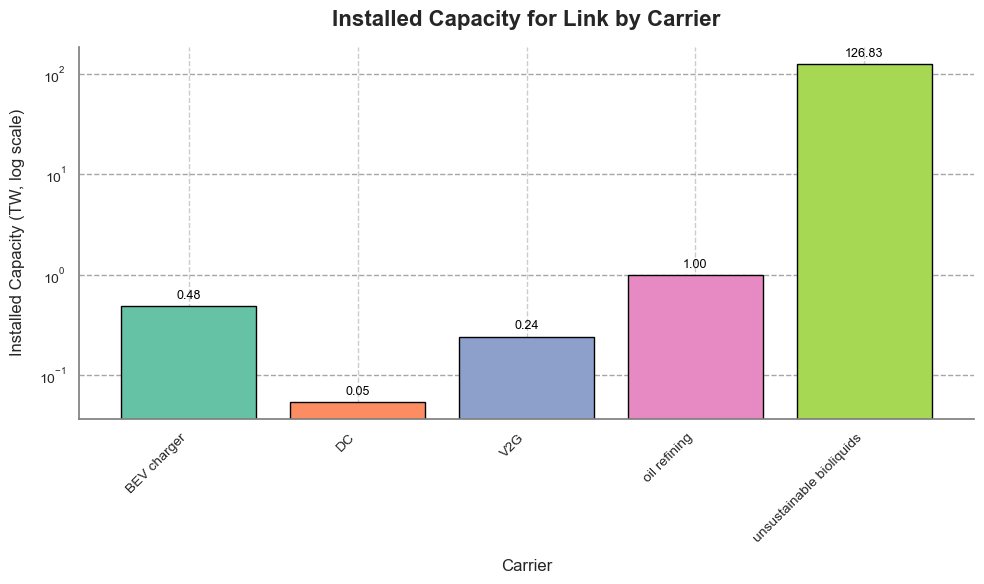

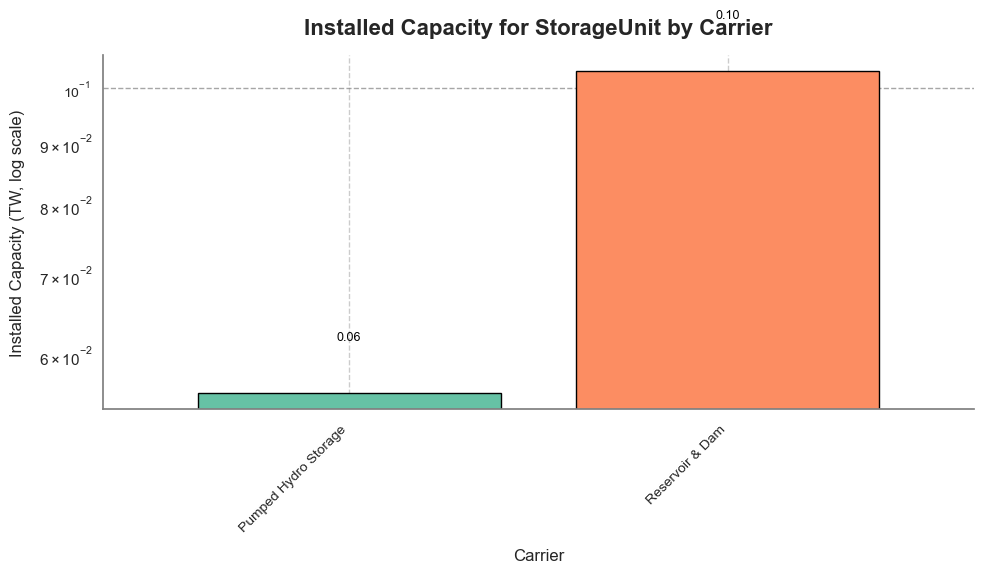

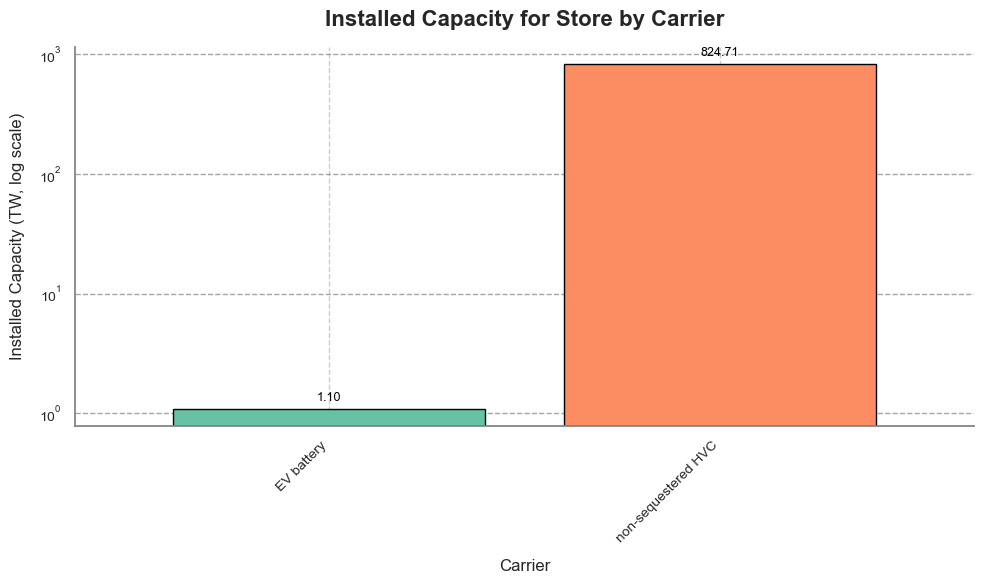

In [31]:


# Set seaborn style for professional aesthetics
sns.set_style("whitegrid", {"grid.linestyle": "--", "grid.alpha": 0.7})

# Get installed capacity data from the model
installed_capacity = n.statistics.installed_capacity()

# Ensure data is a pandas Series with MultiIndex (component, carrier)
if not isinstance(installed_capacity, pd.Series):
    raise ValueError("Expected n.statistics.installed_capacity() to return a pandas Series")

# Convert installed capacity from MW to TW
installed_capacity_gw = installed_capacity / 1e6

# Group data by component
components = installed_capacity_gw.index.get_level_values('component').unique()

# Create a figure for each component
for component in components:
    # Filter data for the current component
    component_data = installed_capacity_gw.xs(component, level='component')
    
    # Create figure
    plt.figure(figsize=(10, 6), dpi=100)
    
    # Use a professional color palette
    colors = sns.color_palette("Set2", n_colors=len(component_data))
    
    # Plot bars
    ax = component_data.plot(
        kind='bar',
        color=colors,
        edgecolor='black',
        width=0.8,
        ax=plt.gca()
    )
    
    # Use logarithmic scale for y-axis due to potential wide range of values
    plt.yscale('log')
    
    # Customize title and labels
    plt.title(
        f"Installed Capacity for {component} by Carrier",
        fontsize=16,
        weight="bold",
        pad=15
    )
    plt.xlabel("Carrier", fontsize=12, labelpad=10)
    plt.ylabel("Installed Capacity (TW, log scale)", fontsize=12, labelpad=10)
    
    # Customize x-axis
    plt.xticks(
        range(len(component_data)),
        [idx for idx in component_data.index],
        rotation=45,
        ha='right',
        fontsize=10
    )
    
    # Customize y-axis
    plt.yticks(fontsize=10)
    plt.grid(axis='y', linestyle='--', alpha=0.7, color="gray")
    
    # Remove top and right spines
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.spines['left'].set_color('gray')
    ax.spines['bottom'].set_color('gray')
    
    # Add value labels on top of bars (in GW, with 2 decimal places)
    for i, v in enumerate(component_data):
        ax.text(
            i, v * 1.1,  # Slightly above the bar
            f"{v:.2f}",  # Show value in GW with 2 decimal places
            ha='center',
            va='bottom',
            fontsize=9,
            color='black'
        )
    
    # Tight layout
    plt.tight_layout()
    
    # Save the plot (optional)
    # plt.savefig(f"installed_capacity_{component}_gw.png", dpi=300, bbox_inches="tight")
    
    # Show the plot
    plt.show()

#### Comments on Installed Capacity Validation for Sector-Coupled PyPSA-Eur Model

We now validate the installed capacities of various technologies in the sector-coupled PyPSA-Eur model. While reservoir and dam storage capacities were already validated in the first section of this notebook, here we focus specifically on other relevant components. For storage units, we examine the pumped hydro storage (PHS) capacity. PyPSA-Eur reports a total installed PHS capacity of 60 GW. In comparison, a peer-reviewed journal article on hydropower infrastructure reports a combined installed capacity of 46.8 GW for pumped-storage hydropower in Europe, indicating a slight overestimation in the PyPSA-Eur dataset ([ScienceDirect, 2024](https://www.sciencedirect.com/science/article/pii/S2352152X24040179)).

For electric vehicle (EV) battery storage, PyPSA-Eur shows an installed capacity of approximately 1.12 TW. Although current public data for present-day EV battery storage capacity in Europe is limited, the IEA projects a future installed capacity of 1.9 TW by 2030 ([IEA Global EV Outlook 2023](https://www.iea.org/reports/global-ev-outlook-2023/prospects-for-electric-vehicle-deployment)).

Regarding AC transmission infrastructure, PyPSA-Eur estimates a total installed alternating current (AC) capacity of about 3.4 TW. Publicly available data from Enerdata places the total AC-connected generation capacity in Europe at approximately 1.5 TW as of 2025. This discrepancy could be attributed to modeling assumptions that include future expansions or sectoral integration not yet fully represented in current statistics ([Enerdata Forecast](https://eneroutlook.enerdata.net/forecast-electricity-capacity-data.html)).

Installed capacity for battery electric vehicle (BEV) chargers is currently not available in public datasets, making direct validation difficult. On the industrial side, PyPSA-Eur assumes an oil refining installed capacity of 1 TW. Public data from the Clingendael International Energy Programme estimates European oil refining capacity at 14.5 million barrels per day (Mb/d) ([CIEP 2017 Report](https://ciep.energy/media/pdf/uploads/CIEP_paper_2017-02_web.pdf)). Using the standard energy content of one barrel of oil (~1.7 MWh), this translates to approximately 24.65 million MWh/day, or about 1.027 TW, aligning closely with the value used in the PyPSA-Eur model.

Lastly, the capacities of electricity generators such as wind, solar, nuclear, and fossil fuel plants were already validated in the earlier part of this notebook. Overall, while some discrepancies exist, mainly due to data timelines, projection-based assumptions, or sectoral coupling effects, the PyPSA-Eur installed capacity values fall within a reasonable range when benchmarked against reliable public sources.
